In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import cPickle as pickle
from spiketopics.helpers import *

%matplotlib inline
sns.set_style('darkgrid')
savefigs = False

/Users/jmxp/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/jmxp/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Load in data

In [2]:
infile = 'data/fitted_model_object.pkl'
gpm = pickle.load(open(infile, 'rb'))
dt = 0.30

In [3]:
df = pd.read_csv('data/prepped_data.csv')
df.head()

,trial,unit,count,category,time
0,69,0,2,Baseline,0
1,69,1,1,Baseline,0
2,69,2,2,Baseline,0
3,69,3,0,Baseline,0
4,69,4,3,Baseline,0


In [4]:
dfm = df.groupby(['time', 'unit']).mean()['count'].unstack(level=0)

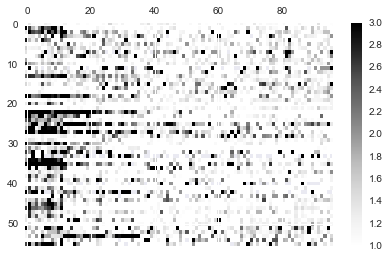

In [5]:
plt.matshow(dfm.values[:, 1::3] / dfm.values[:, ::3], 
            aspect='auto', vmin=1, vmax=3)
plt.colorbar();

In [6]:
dfmm = df.groupby('time').mean()['count']

<Container object of 3 artists>

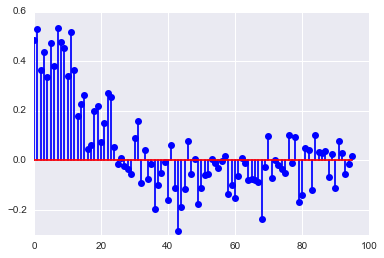

In [7]:
dfrel = (dfmm.values[1::3] - dfmm.values[::3])/dfmm.values[1::3]
plt.stem(range(len(dfrel)), dfrel)

In [8]:
gpm.Nframe.head()

,unit,time,count,lam0,lam1
0,0,0,2,-1.650349,-1.645527
1,1,0,1,-1.821116,-2.104892
2,2,0,2,-0.591888,-0.574412
3,3,0,0,-0.276489,-0.287878
4,4,0,3,-0.749785,-0.801012


In [9]:
if gpm.regressors:
    gpm.Xframe.head()

# Plot inferred categories as matrix

In [10]:
xi = gpm.nodes['HMM'].nodes['z'].z[1].copy()
T, K = xi.shape
print xi.shape

(288, 10)


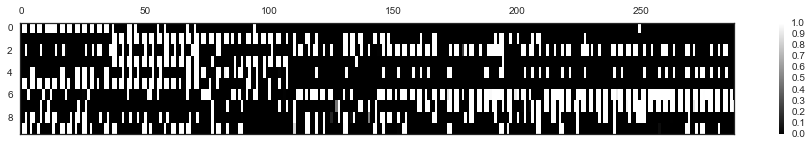

In [11]:
matshow(xi[:500].T, vmin=0, vmax=1);
plt.colorbar();

Every third timestep is a different stimulus. Each stimulus has
1. pre-trial baseline
1. stimulus presentation
1. post-stimulus period

So let's plot these individually:

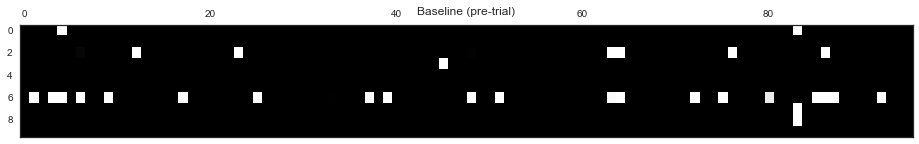

In [12]:
matshow(xi[::3].T, vmin=0, vmax=1)
plt.title('Baseline (pre-trial)')

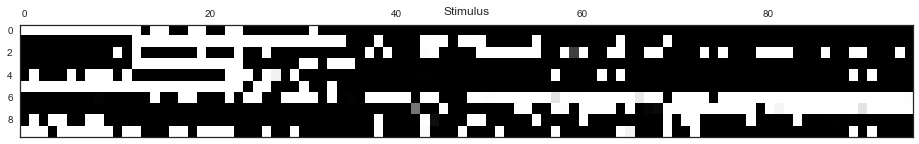

In [13]:
matshow(xi[1::3].T, vmin=0, vmax=1)
plt.title('Stimulus')

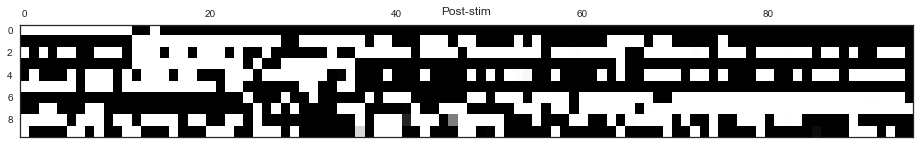

In [14]:
matshow(xi[2::3].T, vmin=0, vmax=1)
plt.title('Post-stim')

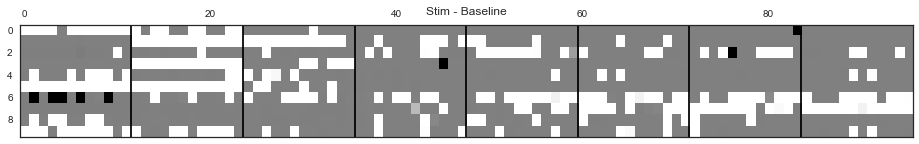

In [15]:
matshow(xi[1::3].T - xi[::3].T, vmin=-1, vmax=1)
plt.title('Stim - Baseline')
for ind in range(0, xi.shape[0]//3, 12):
    plt.axvline(ind - 0.5, 0, xi.shape[-1], color='black')

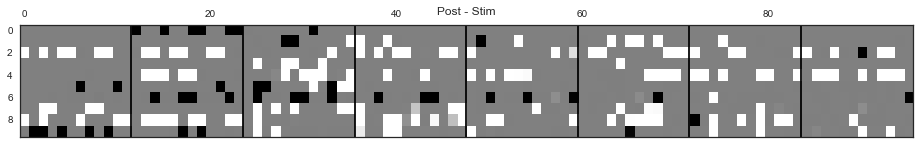

In [16]:
matshow(xi[2::3].T - xi[1::3].T, vmin=-1, vmax=1)
plt.title('Post - Stim')
for ind in range(0, xi.shape[0]//3, 12):
    plt.axvline(ind - 0.5, 0, xi.shape[-1], color='black')

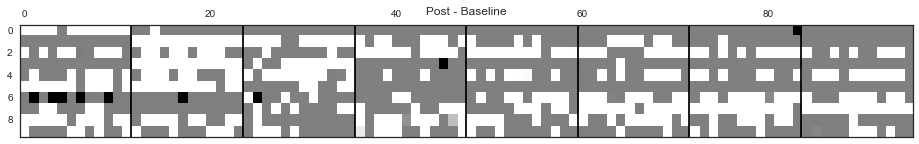

In [17]:
matshow(xi[2::3].T - xi[::3].T, vmin=-1, vmax=1)
plt.title('Post - Baseline')
for ind in range(0, xi.shape[0]//3, 12):
    plt.axvline(ind - 0.5, 0, xi.shape[-1], color='black')

## Weight categories by effect sizes

First, get mean effect size for each firing rate effect:

In [18]:
th = gpm.nodes['fr_latents_mean']
cc = gpm.nodes['fr_latents_shape']

th_pars = np.c_[th.post_shape, th.post_rate].T
cc_pars = np.c_[cc.post_shape, cc.post_rate].T

effsize = th_pars[0] / th_pars[1]  # mean of posterior for mean effect size

In [19]:
effsize

array([ 0.8008021 ,  1.06565492,  1.09332366,  1.07279522,  0.96695422,
        0.86495709,  0.93686912,  1.02519379,  1.02479371,  0.93117782])

In [20]:
# make a normalizer so we can set the colormap midpoint
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_invalid(np.interp(value, x, y))

norm = MidpointNormalize(midpoint=1., vmin=0.8, vmax=1.2)
cmap = plt.cm.RdBu_r
cmap.set_bad(color='k', alpha=1.0)

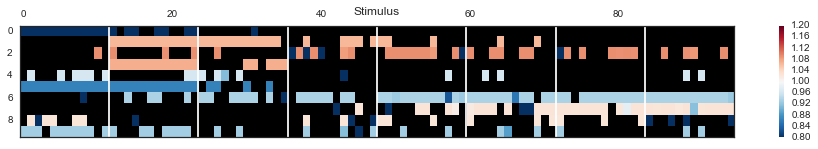

In [21]:
X = (xi[1::3] * effsize).T
X[np.abs(X) < 1e-4] = np.nan

with sns.axes_style("white"):
    plt.figure(figsize=(20, 8))
    ax = plt.matshow(X, aspect='auto', cmap=cmap, norm=norm);

plt.title('Stimulus')
for ind in range(0, xi.shape[0]//3, 12):
    plt.axvline(ind - 0.5, 0, xi.shape[-1], color='white')
plt.colorbar();

## Make $\xi$ dataframe:

In [22]:
xif = pd.DataFrame(xi)
xif.columns = ['Z' + str(k) for k in range(K)]
xif.index.name = 'time'
xif = xif.reset_index()

# Posteriors for effects

## Baselines

In [23]:
bl = gpm.nodes['baseline']
unit_baseline_means = bl.expected_x() / dt

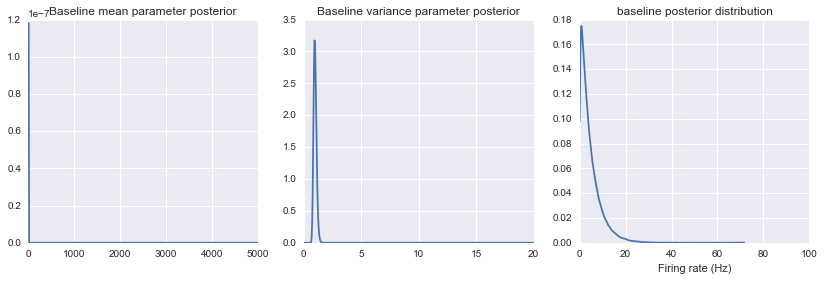

In [24]:
plt.figure(figsize=(14, 4))

th = gpm.nodes['baseline_mean']
cc = gpm.nodes['baseline_shape']
th_pars = [th.post_shape, th.post_rate]
cc_pars = [cc.post_shape, cc.post_rate]
samples = gamma_from_hypers(th_pars, cc_pars, 1e5)

plt.subplot(1, 3, 1)
xx = np.linspace(0, 5000, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0], scale=th_pars[1]/dt))
plt.title('Baseline mean parameter posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 20, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0], scale=cc_pars[1]))
plt.title('Baseline variance parameter posterior');

plt.subplot(1, 3, 3)
sns.kdeplot(samples / dt, gridsize=1e4, clip=(0, 100))
plt.title('baseline posterior distribution')
plt.xlabel('Firing rate (Hz)')
plt.xlim(0, 100);

## Regressors

In [25]:
if gpm.regressors:
    plt.figure(figsize=(8, 6));
    inferred_means = gpm.nodes['fr_regressors'].expected_x()
    R = inferred_means.shape[1]
    for r in xrange(R):
        plt.hist(inferred_means[:, r], bins=50, normed=True, alpha=0.25, label='X' + str(r))
    plt.title('Regression effects');
    plt.legend()
    plt.ylim(0, 5);
    plt.xlim(0, 5);

## Latent Categories

In [26]:
frn = gpm.nodes['fr_latents']
fr_mean_effect = frn.expected_x()

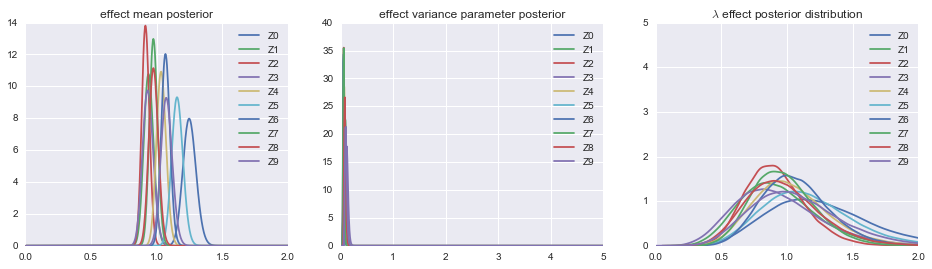

In [27]:
plt.figure(figsize=(16, 4))

th = gpm.nodes['fr_latents_mean']
cc = gpm.nodes['fr_latents_shape']

th_pars = np.c_[th.post_shape, th.post_rate].T
cc_pars = np.c_[cc.post_shape, cc.post_rate].T

plt.subplot(1, 3, 1)
xx = np.linspace(0, 2, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0, kk], scale=th_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect mean posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 5, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0, kk], scale=cc_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect variance parameter posterior');

plt.subplot(1, 3, 3)
for kk in xrange(K):
    samples = gamma_from_hypers(th_pars[:, kk], cc_pars[:, kk], 1e5)
    sns.kdeplot(samples, gridsize=1e4, clip=(0, 10), label='Z' + str(kk))
plt.legend()
plt.title(r'$\lambda$ effect posterior distribution')
plt.xlim(0, 2);
plt.ylim(0, 5);

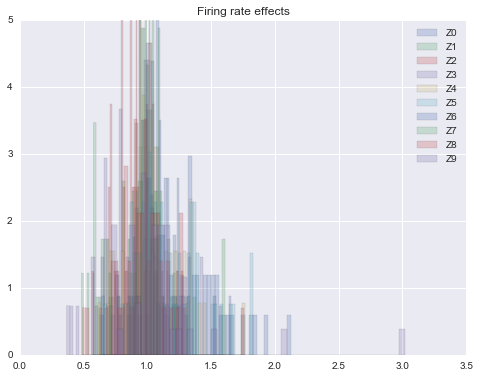

In [28]:
plt.figure(figsize=(8, 6))

inferred_effects = gpm.nodes['fr_latents'].expected_x()
for kk in xrange(K):
    plt.hist(inferred_effects[..., kk], bins=50, normed=True, alpha=0.25, label='Z' + str(kk));
plt.legend();
plt.title('Firing rate effects');
plt.ylim(0, 5);

## Sparsity

In [31]:
if 'fr_latents_feature' in gpm.nodes:
    matshow(gpm.nodes['fr_latents_feature'].expected_x().T)

    gpm.nodes['fr_latents_sparsity'].expected_x()[0]

## Overdispersion

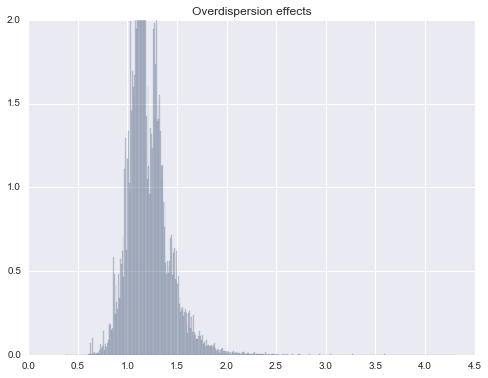

In [32]:
if gpm.overdispersion:
    plt.figure(figsize=(8, 6))

    inferred_means = gpm.nodes['overdispersion'].expected_x().ravel()
    plt.hist(inferred_means, bins=500, normed=True, alpha=0.25);
    plt.title('Overdispersion effects');
    plt.ylim(0, 2);

# Load and prepare coded features:

In [33]:
df.head()

,trial,unit,count,category,time
0,69,0,2,Baseline,0
1,69,1,1,Baseline,0
2,69,2,2,Baseline,0
3,69,3,0,Baseline,0
4,69,4,3,Baseline,0


In [34]:
df2 = df.copy()
df2['value'] = 1
df2 = df2.drop(['trial', 'unit'], axis=1).drop_duplicates()
catdf = pd.pivot_table(df2, values='value', index=['time'], columns=['category']).reset_index().fillna(0)
catdf.columns.name = ''
catdf.head()

,time,Animals,Baseline,Bodies,Faces,Fruit,Manmade,Natural,Pattern,Scene
0,0,0,1,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0
2,2,0,0,0,1,0,0,0,0,0
3,3,0,1,0,0,0,0,0,0,0
4,4,0,0,0,1,0,0,0,0,0


In [35]:
edf = pd.merge(catdf, xif).sort_values(by='time').drop(['time', 'Baseline'], axis=1)
edf.head()

,Animals,Bodies,Faces,Fruit,Manmade,Natural,Pattern,Scene,Z0,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9
0,0,0,0,0,0,0,0,0,2.986989e-46,2.424718e-25,8.170855e-10,2.625160e-30,1.163234e-15,5.983813e-31,4.007601e-08,1.520915e-13,3.596513e-20,7.102290e-18
1,0,0,1,0,0,0,0,0,1.000000e+00,1.138974e-52,2.234766e-18,8.137399e-69,5.751562e-21,1.000000e+00,4.727657e-24,1.493384e-43,3.085998e-31,1.000000e+00
2,0,0,1,0,0,0,0,0,1.000000e+00,2.977762e-45,1.000000e+00,9.923200e-33,1.340683e-08,1.000000e+00,5.885256e-15,1.948705e-20,1.000000e+00,1.000000e+00
3,0,0,0,0,0,0,0,0,2.033064e-42,1.472555e-34,4.455542e-13,1.383357e-36,1.061817e-14,3.782079e-23,9.999985e-01,5.553282e-11,6.046483e-11,1.711612e-22
4,0,0,1,0,0,0,0,0,1.000000e+00,7.602831e-101,2.566694e-43,1.470624e-106,1.000000e+00,1.000000e+00,3.562457e-10,6.787817e-23,1.000000e+00,1.000000e+00


# View results:

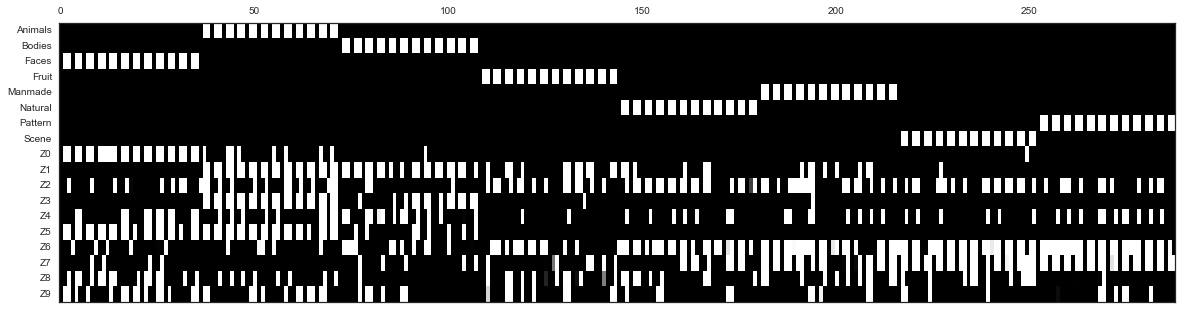

In [36]:
if savefigs:
    sns.set_context('poster', font_scale=1)

# plot a section in time; each row is a regressor; bottom rows are inferred categories
trng = slice(None)
matshow(edf.iloc[trng].values.T, vmin=0, vmax=1);
col_labels = edf.columns
plt.yticks(xrange(len(col_labels)), col_labels);
plt.gcf().set_size_inches([20, 5])

if savefigs:
    plt.savefig('roitman_recovery.svg')
    sns.set()

## Overlap analysis:

Define the overlap as the maximum of the match or mismatch percentage. That is, if $x$ and $y$ are binary vectors, 
$$
\mathrm{overlap} = \max \{ \mathbb{E}[xy + (1-x)(1-y)], \mathbb{E}[(1-x)y + x(1-y)]\}
$$

In [37]:
match = (edf.T.dot(edf) + (1 - edf.T).dot(1 - edf)) / T
mismatch = (edf.T.dot(1 - edf) + (1 - edf.T).dot(edf)) / T
overlap = np.maximum(match, mismatch)

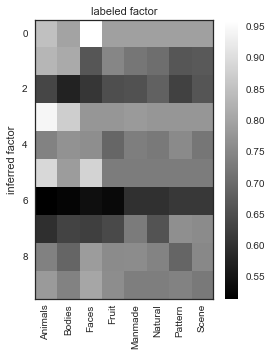

In [38]:
row_labels = edf.columns[:-K]
matshow(overlap.values[-K:,:-K]) #, vmin=0.5, vmax=1)
plt.ylabel('inferred factor')
plt.xlabel('labeled factor')
plt.colorbar();

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5)
plt.xticks(xrange(len(row_labels)), row_labels, rotation='vertical', horizontalalignment='center');

In [39]:
overlap.iloc[-K:, :]

,Animals,Bodies,Faces,Fruit,Manmade,Natural,Pattern,Scene,Z0,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9
,,,,,,,,,,,,,,,,,,
Z0,0.850694,0.802083,0.961806,0.795139,0.795139,0.795139,0.795139,0.795139,1.000000,0.690972,0.599954,0.802083,0.746794,0.902776,0.547200,0.596015,0.765000,0.788724
Z1,0.833333,0.812500,0.666667,0.750000,0.722222,0.708333,0.666667,0.673611,0.690972,1.000000,0.624141,0.861111,0.715270,0.781249,0.509038,0.550915,0.713153,0.742395
Z2,0.638146,0.575635,0.610383,0.652029,0.658982,0.688353,0.631136,0.665762,0.599954,0.624141,0.997846,0.596458,0.665811,0.586064,0.644293,0.674189,0.675040,0.623491
Z3,0.944444,0.875000,0.777778,0.777778,0.784722,0.777778,0.777778,0.777778,0.802083,0.861111,0.596458,1.000000,0.736503,0.878471,0.529870,0.578654,0.692148,0.750584
Z4,0.743324,0.770876,0.764155,0.694763,0.736392,0.729160,0.757235,0.722488,0.746794,0.715270,0.665811,0.736503,0.999028,0.753857,0.545935,0.675939,0.692567,0.772072
Z5,0.892360,0.788193,0.885415,0.732638,0.732638,0.732638,0.732640,0.732638,0.902776,0.781249,0.586064,0.878471,0.753857,0.999997,0.588864,0.540461,0.730284,0.781784
Z6,0.516035,0.525689,0.543727,0.532628,0.601407,0.601044,0.615788,0.615908,0.547200,0.509038,0.644293,0.529870,0.545935,0.588864,0.997066,0.699787,0.517771,0.502403
Z7,0.599487,0.634210,0.627265,0.644384,0.731784,0.661933,0.765359,0.758870,0.596015,0.550915,0.674189,0.578654,0.675939,0.540461,0.699787,0.996487,0.669867,0.619816
Z8,0.740691,0.692139,0.789303,0.759291,0.761414,0.747604,0.692185,0.754520,0.765000,0.713153,0.675040,0.692148,0.692567,0.730284,0.517771,0.669867,0.996581,0.740228


## Mutual Information

In [40]:
mi_mat = mutual_information_matrix(edf.iloc[:, :-K].values, edf.iloc[:, -K:].values)

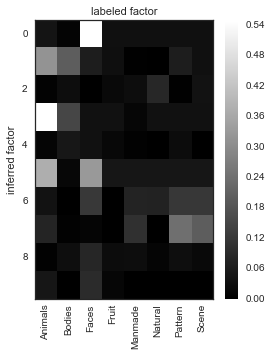

In [41]:
row_labels = edf.columns[:-K]
matshow(mi_mat.T, vmin=0, vmax=0.55)
plt.ylabel('inferred factor')
plt.xlabel('labeled factor')
plt.colorbar();

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5)
plt.xticks(xrange(len(row_labels)), row_labels, rotation='vertical', horizontalalignment='center');

In [42]:
pd.DataFrame(mi_mat.T, columns=row_labels)

,Animals,Bodies,Faces,Fruit,Manmade,Natural,Pattern,Scene
0,0.044116,0.010605,0.648296,0.034715,0.034715,3.471464e-02,0.034715,0.034715
1,0.317981,0.201769,0.062776,0.033057,0.003956,1.105747e-15,0.062776,0.035399
2,0.008354,0.029715,0.000373,0.021265,0.029986,8.531907e-02,0.004073,0.039997
3,0.568766,0.151228,0.038407,0.038407,0.013697,3.840684e-02,0.038407,0.038407
4,0.011189,0.050150,0.038219,0.018030,0.005631,1.784472e-03,0.027563,0.000124
5,0.374162,0.015802,0.329474,0.048054,0.048054,4.805406e-02,0.048015,0.048054
6,0.039087,0.000781,0.122005,0.000001,0.075349,7.444763e-02,0.119651,0.120123
7,0.079200,0.006299,0.012495,0.001164,0.104380,1.596617e-03,0.239136,0.201617
8,0.006226,0.031385,0.083085,0.025802,0.028821,1.203424e-02,0.031267,0.019596
9,0.047386,0.000841,0.094401,0.014469,0.000046,2.345403e-05,0.000934,0.001701
